# Pop-Up Course: Better metal forming by linking experiment, modeling, and process control  
#### July 29-30, 2019

## Monte Carlo Grain Growth Simulation

### What are grains and grain boundaries?

A crystalline material is one in which atoms are arranged on well-defined, periodic, crystallographic planes. A polycrystalline material can be defined as one in which crystalline regions or domains are separated by well-defined boundaries. Such domains are called grains, and the boundaries separating them are known as grain boundaries. While grains are crystalline and hence 'ordered' in nature, the grain boundaries are disordered, i.e., atoms in the grain boundaries are irregularly arranged. The disordered nature of a grain boundary results in an excess free energy compared to the bulk grain. 


### Why are grain boundaries important to a material?

Grain boundaries disrupt the continuity in the ordered arrangement of atoms. Hence, they affect properties such as electrical conductivity and solute diffusivity. Since the arrangement of atoms in a boundary are different compared to in a grain, 


### Why does grain growth occur?

Grain boundaries are regions of disordered material and thus have an excess free energy associated with them. A polycrystalline material thus contains excess energy proportional to the grain boundary area, and tends to reduce this energy through grain growth. The direction of grain growth is provided by the curvature of grain boundaries, with the growth always directed towards the center of curvature. Burke\cite{Burke1949} provided a mathematical construct for quantifying grain growth in isothermal conditions:

\begin{equation} \label{eqn:burke-turnbull}
D^{2}-{D_{0}}^{2} = kt
\end{equation}

where $D_{0}$ and $D$ are mean grain diameters at times 0 and t respectively, and n is the grain size exponent. 


### Can uncontrolled grain growth affect a material's performance? 





## Grain Growth, visualized in 2 dimensions

<img src = "gg.gif">

## Grain Growth, visualized in 3 dimensions

![GGUrl](https://upload.wikimedia.org/wikipedia/commons/3/38/Grgr3d_small.gif)

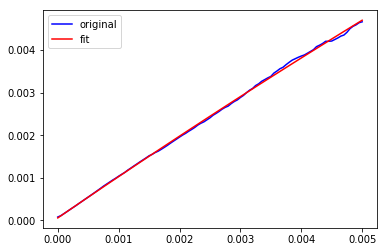

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
df = pd.read_csv("Lin.txt", sep = '\t', header=None, names=['t', 'area', 'dia'])
time = df['t']
d = df['area']
c1, c2, c3 = np.polyfit(time, d, 2)

plt.plot(time, d, color = 'b', label = 'original')
plt.plot(time, c3 + c2*time + c1*time*time, color = 'r', label = 'fit')
plt.legend()
plt.show()

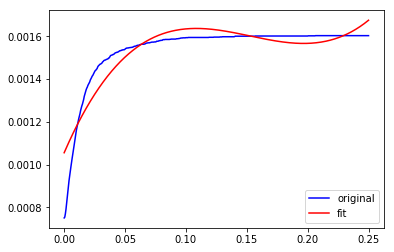

In [3]:
df1 = pd.read_csv("NonLin.txt", sep = '\t', header=None, names=['t', 'area', 'dia', 'a', 'b', 'c', 'd'])
time1 = df1['t']
d1 = df1['area']
c1, c2, c3, c4 = np.polyfit(time1, d1, 3)

plt.plot(time1, d1, color = 'b', label = 'original')
plt.plot(time1, c4 + c3*time1 + c2*time1*time1 + c1*time1**3, color = 'r', label = 'fit')
plt.legend()
plt.show()

In a typical crystalline material, solute atoms can occupy either the substitional position or the interstitial position in the lattice. Due to the size mismatch between solute and solvent atoms, the presence of solute atoms in the lattice always leads to excess strain energy. A substitutional solute atom is also involved with new bonds with the neighboring atoms, and hence leading to a possibility of excess chemical energy. Due to these mechanical and chemical excess energies, it is often energetically favorable for the solute atoms to occupy a position in the disordered grain boundary region. This also lowers the grain boundary energy. In addition, the presence of impurities in the lattice increases the entropic component of the system and thus reduces the total Gibbs free energy. Hence, an equilibrium is obtained between solute mole fraction at the boundary and solute mole fraction in the bulk. From a thermodynamic point of view, this balance is quantitatively explained by Mclean's segregation equation f, shown in Equation 2. This relationship assumes an infinitely fast solute diffusion in the bulk region and a monolayer of solute atoms at the grain boundary. Inducing segregation at the grain boundaries by alloying is a well-known method to control grain coarsening and retard grain growth. The mechanism that is responsible for this retardation depends on the dynamics of the solute at the boundary. The excess Gibbs free energy at the grain boundaries could be reduced by the segregation of solute. Alternatively, since grain boundaries are prime locations for heterogeneous nucleation, solute atoms could precipitate to form a secondary phase at a boundary. The new precipitated phase inhibits the boundary's mobility via a drag force, also known as Zener drag. The Zener drag force could also be provided by large solute particles. Since the driving force for grain growth is proportional to the product of grain boundary mobility, energy, and curvature, grain growth is slowed down by both the above mentioned mechanisms. The model adopted in this paper assumes that grain growth is inhibited by solute segregating to boundaries, in accordance with. A few examples of experimental research that study solute segregation at boundaries are listed here. With an appropriate material design and selection of operation conditions, it is theoretically possible to reduce the grain boundary energy to zero, as demonstrated in the literature.  When the boundary energy approaches a value of zero, grain boundary velocity tends to a value of zero and the material reaches a metastable state, corresponding to a local minimum in the Gibbs free energy. 

### MC Description

#### [Code Intro/Algo] explaination

In [4]:
# Import required libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython import display
import time

# Inline Plots
%matplotlib inline

Make a 2D square lattice:

In [5]:
nlp = 100  # number of lattice points
N = (nlp + 1) * (nlp + 1)
Q = N  # Number of states in Q-state potts model
X = np.linspace(0, 1, nlp + 1)
x, y = np.meshgrid(X, X)

### Functions:

#### Neighborhood matrix and figure of a 3x3 lattice

In [6]:
def createNeighborStateMatrix(i, j,state):
    Jm1=j-1
    Jp1=j+1
    Im1=i-1
    Ip1=i+1
    
    # Periodic Boundary Condition
    if(i==0):
        Im1=len(state)-1
    if(i==len(state)-1):
        Ip1=0        
    if(j==0):
        Jm1=len(state)-1
    if(j==len(state)-1):
        Jp1=0
    # 3x3 matrix of state all cells surrounding current lattice point
    neighborStateMatrix = np.array([[state[Im1, Jm1], state[Im1, j], state[Im1, Jp1]],
                           [state[i, Jm1], state[i, j], state[i, Jp1]],
                           [state[Ip1, Jm1], state[Ip1, j], state[Ip1, Jp1]]])
    return neighborStateMatrix


#### Formula for Energy change and kronecker delta and explaination
$$
\Delta E=J \sum_{j=1}^{N_{n}}\left[\delta\left(S_{i}^{0}, S_{i}^{j}\right)-\delta\left(S_{i}^{n}, S_{i}^{j}\right)\right]
$$

In [7]:
def calculateKroneckerDelta(neighborStateMatrix):
    kd = np.zeros([1, 8])
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[0, 0]):
        kd[0, 0] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[0, 1]):
        kd[0, 1] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[0, 2]):
        kd[0, 2] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[1, 2]):
        kd[0, 3] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[2, 2]):
        kd[0, 4] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[2, 1]):
        kd[0, 5] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[2, 0]):
        kd[0, 6] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[1, 0]):
        kd[0, 7] = 1
    return sum(sum(kd))



#### Some text about randomly flipping orientaiton and a3x3 figure with different state

In [8]:

def changeState(neighborStateMatrix):
    neighborI=1
    neighborJ=1
    
    while (neighborI==1) and (neighborJ==1):
        neighborI=np.random.randint(3)
        neighborJ=np.random.randint(3)
        neighborStateMatrix[1,1]=neighborStateMatrix[neighborI,neighborJ];
    return  neighborStateMatrix


Matrices initialized:

In [9]:
state = np.random.randint(Q, size=(x.shape))
colormatrix = np.random.rand(Q, 3)
neighborStateMatrix = np.zeros([3, 3])

# Boundary detection
isinside = np.ones(shape=(x.shape))
for i in range(0, nlp + 1):
    for j in range(0, nlp + 1):
        if (i == 0) or (j == 0) or (i == nlp) or (j == nlp):
            isinside[i,j] = 0

**MCS Loop Starts here:**

In [ ]:
for mcs in range(0,100):
    for n in range(0, N):
        # Pick random lattice cite
        i = np.random.randint(0, len(x))
        j = np.random.randint(0, len(x))
        neighborStateMatrix = createNeighborStateMatrix(i, j, state)
        energyBeforeChange = calculateKroneckerDelta(neighborStateMatrix)
        neighborStateMatrix=changeState(neighborStateMatrix)
        energyAfterChange = calculateKroneckerDelta(neighborStateMatrix)
        dE=energyBeforeChange-energyAfterChange
        if dE<0:
            state[i,j]=neighborStateMatrix[1,1]
    # Plotting as squares
    if (mcs%10.0==0):
        fig, ax = plt.subplots(1)
        for i in range(0, nlp + 1):
           for j in range(0, nlp + 1):
               rect = patches.Rectangle((x[i, j]-(0.5 / nlp), y[i, j]-(0.5 / nlp)), 1.0 / nlp, 1.0 / nlp,linewidth=1, edgecolor='none', facecolor=colormatrix[state[i, j], :])
               ax.add_patch(rect)
        plt.gca().set_aspect('equal', adjustable='box')
        display.display(plt.gcf())
        display.clear_output(wait=True)

KeyboardInterrupt: 